## This notebook was used to figure out the image generation process.
The result of this experimentation is makedata.py. 

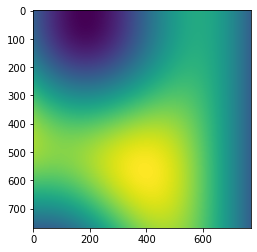

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

def perlin(x,y,seed=0):
    # permutation table
    np.random.seed(seed)
    p = np.arange(256,dtype=int)
    np.random.shuffle(p)
    p = np.stack([p,p]).flatten()
    # coordinates of the top-left
    xi = x.astype(int)
    yi = y.astype(int)
    # internal coordinates
    xf = x - xi
    yf = y - yi
    # fade factors
    u = fade(xf)
    v = fade(yf)
    # noise components
    n00 = gradient(p[p[xi]+yi],xf,yf)
    n01 = gradient(p[p[xi]+yi+1],xf,yf-1)
    n11 = gradient(p[p[xi+1]+yi+1],xf-1,yf-1)
    n10 = gradient(p[p[xi+1]+yi],xf-1,yf)
    # combine noises
    x1 = lerp(n00,n10,u)
    x2 = lerp(n01,n11,u) 
    return lerp(x1,x2,v) 

def lerp(a,b,x):
    "linear interpolation"
    return a + x * (b-a)

def fade(t):
    "6t^5 - 15t^4 + 10t^3"
    return 6 * t**5 - 15 * t**4 + 10 * t**3

def gradient(h,x,y):
    "grad converts h to the right gradient vector and return the dot product with (x,y)"
    vectors = np.array([[0,1],[0,-1],[1,0],[-1,0]])
    g = vectors[h%4]
    return g[:,:,0] * x + g[:,:,1] * y


def crop (nparray, xlen, ylen):
    return nparray[0:ylen, 0:xlen]

def normalize(nparray):
    maxval = np.amax(nparray)
    minval = np.amin(nparray)
    data = nparray + np.abs(minval)
    data = data / (maxval + np.abs(minval))
    return data

def get_perlin(squarelen=768):
    lin = np.linspace(0,1,squarelen,endpoint=False)
    x,y = np.meshgrid(lin,lin) 
    data = perlin(x,y,seed=int(time.time()))
    return data

data = get_perlin()

# cast to 16 bits
data = normalize(data)
data = data * 16
data.astype(np.int16)
plt.imshow(data,origin='upper')





In [167]:
import bz2 

def to_bz2(filename):
    with open(filename, 'rb') as uncomp:
        comp = bz2.compress(uncomp.read())
    with open(filename + '.bz2', 'wb') as target:
        target.write(comp)


In [169]:
from astropy.io import fits 
from skimage.io import imsave
from auto_stretch.stretch import Stretch

import time
import os

def make_data_files(header_dict={}):
    filename = "generated_files/generated.fits"

    hdu = fits.PrimaryHDU()
    hdu.data = perlin(x,y,seed=int(time.time()))

    # add header to fits data
    for key in header_dict:
        hdu.header[key] = header_dict[key]
    
    # write header text file
    with open('generated_files/generated.txt', 'w') as txt:
        txt.write(str(hdu.header))

    # write jpg file
    positive_jpg_data = hdu.data + np.abs(np.amin(hdu.data)) # make all vals positive
    jpg_data = Stretch().stretch(positive_jpg_data)  # stretch
    jpg_8 = (jpg_data * 256).astype('uint8')  # convert to 8-bit int for jpg
    imsave("generated_files/generated.jpg", jpg_8)

    # write fits file
    hdu.writeto(filename, overwrite=True)

    # write bz2 fits file
    to_bz2(filename)

#make_data_files()

In [170]:
import datetime

def make_header():
    header_dict = {
        "date-obs": datetime.datetime.now().isoformat().split('.')[0],
        "exptime": np.random.randint(1,30),
        "filter": "W",
        "imagetyp": "TEST DATA",

    }
    #print(header_dict)
    return header_dict

#make_header()

{'date-obs': '2021-05-17T14:45:18',
 'exptime': 29,
 'filter': 'W',
 'imagetyp': 'TEST DATA'}

In [172]:
header = make_header()
make_data_files(header)

In [92]:
fits_file = fits.open('generated_files/generated.fits.bz2')
header = fits_file[0].header
with open('generated_files/generated.txt', 'w') as txt:
    txt.write(str(header))
    
print(header)


SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                   20                                                  NAXIS2  =                   20                                                  EXTEND  =                    T                                                  HKEY    = 'header val'                                                          END                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [108]:
a = np.eye(3)
a += 1
a

array([[2., 1., 1.],
       [1., 2., 1.],
       [1., 1., 2.]])